Loaded layout: 2558425b9b974aaa113922d65cc600ff.json


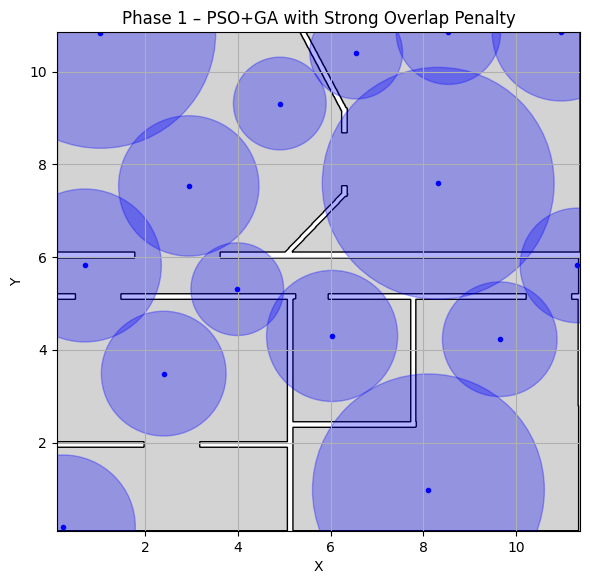

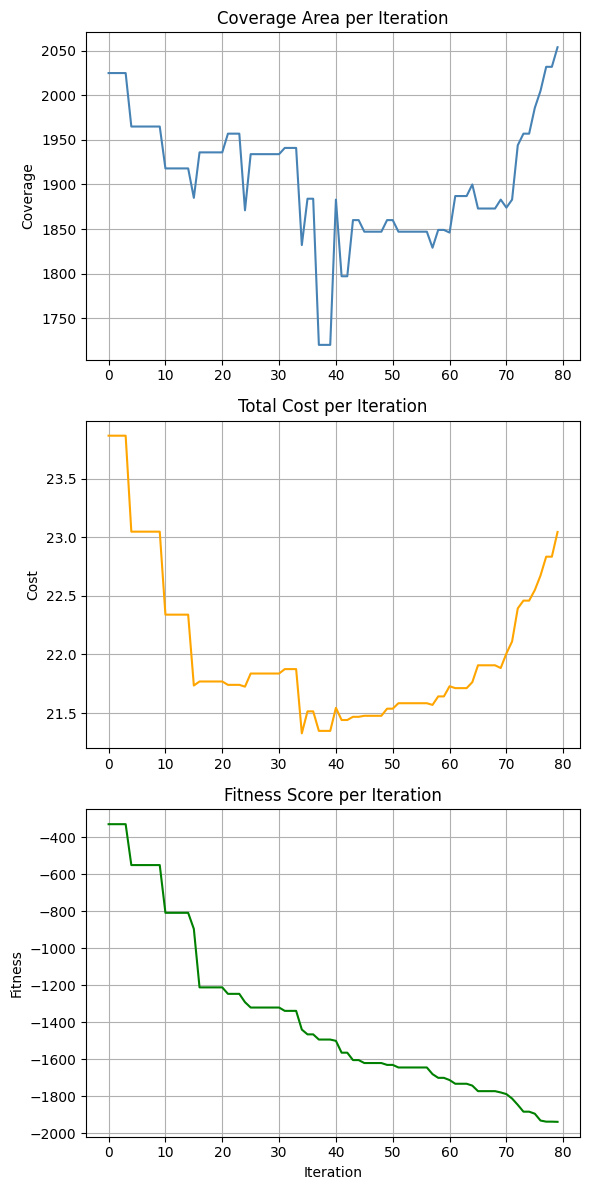

In [1]:
##### Phase One PSO + GA
import os
import random
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path

# --------------------- Load Layout ---------------------
# Step 1: Randomly pick a layout file
layout_dir = "houseexpo_layouts"
json_files = [f for f in os.listdir(layout_dir) if f.endswith(".json")]
selected_file = random.choice(json_files)
selected_path = os.path.join(layout_dir, selected_file)

# Step 2: Save selected layout filename to be reused in phase 2
with open("selected_layout.txt", "w") as f:
    f.write(selected_file)

# Step 3: Load layout data
with open(selected_path, "r") as f:
    layout_data = json.load(f)

# Step 4: Parse layout
polygon_coords = layout_data["verts"]
room_boxes     = layout_data["room_category"]
min_x, min_y   = layout_data["bbox"]["min"]
max_x, max_y   = layout_data["bbox"]["max"]
layout_poly    = Path(polygon_coords)

print(f"Loaded layout: {selected_file}")


# --------------------- Parameters ---------------------
num_sensors         = 15
sensor_radius_bounds = (1.0, 2.5)
num_particles       = 30
num_iterations      = 80

# PSO+GA hyperparams
w_inertia     = 0.7
c1, c2        = 1.4, 1.4
ga_generations = 5
mutation_rate  = 0.1

# Overlap penalty weight (increased) & overlap‑point penalty & radius cost
w_overlap      = 2.0    # Previously set to 0.5; raised
w_overlap_pts  = 1.0    # New: penalty for each grid point covered by two or more sensors
w_radius       = 0.1

# --------------------- Prepare Grid ---------------------
grid_resolution = 0.2
# Set the spacing between grid points (in meters or layout units). Smaller = finer grid.

# Generate evenly spaced x and y coordinates within the layout bounds.
x_coords = np.arange(min_x, max_x, grid_resolution)
y_coords = np.arange(min_y, max_y, grid_resolution)

# Create a full 2D grid of (x, y) coordinate pairs using the coordinate arrays.
xx, yy = np.meshgrid(x_coords, y_coords)

# Flatten the meshgrid into a 2D array of shape (N, 2) for all grid point coordinates.
GRID = np.c_[xx.ravel(), yy.ravel()]

# Check which grid points fall inside the layout polygon (e.g., rooms/walls).
# Returns a boolean array: True if point is inside, False if outside.
valid = layout_poly.contains_points(GRID)

# --------------------- Fitness Function ---------------------
def evaluate_solution(sol):
    cov = np.zeros(len(GRID), dtype=int)
    radius_cost = 0.0

    # Cumulative coverage and radius cost
    for i in range(num_sensors):
        # Extract the x, y position and sensing radius r of the i-th sensor from the solution vector
        x, y, r = sol[3*i:3*i+3]

        # If the sensor is placed outside the layout polygon, return infinite cost (invalid solution)
        if not layout_poly.contains_point((x, y)):
            return np.inf

        # Compute the Euclidean distance from the i-th sensor to all grid points
        d = np.hypot(GRID[:,0] - x, GRID[:,1] - y)

        # Create a boolean mask where True if the grid point is within radius r of the sensor
        mask = (d <= r)

        # Add this sensor's coverage (1s and 0s) to the cumulative coverage count
        cov += mask.astype(int)

        # Accumulate the radius cost (e.g., could be proportional to energy or financial cost)
        radius_cost += r

    # Restrict coverage to only valid grid points (those inside the layout polygon)
    cov = cov * valid

    # Count how many unique grid points are covered by at least one sensor
    unique_cov = np.sum(cov > 0)

    # Total coverage count minus unique grid points gives overlapping coverage (i.e., over-covered)
    overlap_cov = np.sum(cov) - unique_cov

    # Count how many grid points are covered by more than one sensor (i.e., actual overlap count)
    overlap_pts = np.sum(cov > 1)

    # Objective: minimize the following expression
    #  - unique_cov   (max coverage)
    #  + w_overlap*overlap_cov
    #  + w_overlap_pts*overlap_pts
    #  + w_radius*radius_cost
    fitness = (
        + w_overlap * overlap_cov
        + w_overlap_pts * overlap_pts
        + w_radius * radius_cost
        - unique_cov
    )
    return fitness

# --------------------- Coverage Helper ---------------------
def evaluate_coverage(sol):
    cov = np.zeros(len(GRID), dtype=int)
    for i in range(num_sensors):
        x, y, r = sol[3*i:3*i+3]
        d = np.hypot(GRID[:,0] - x, GRID[:,1] - y)
        mask = (d <= r)
        cov += mask.astype(int)
    cov = cov * valid
    return (cov > 0).astype(int)

# --------------------- Convergence Tracking ---------------------
coverage_per_iter = []
cost_per_iter = []
fitness_per_iter = []

# --------------------- PSO + GA Setup ---------------------
dim = num_sensors * 3
lb  = np.tile([min_x, min_y, sensor_radius_bounds[0]], num_sensors)
ub  = np.tile([max_x, max_y, sensor_radius_bounds[1]], num_sensors)

# Initialize particles
pos    = np.random.uniform(lb, ub, (num_particles, dim))
vel    = np.zeros_like(pos)
pbest  = pos.copy()
pval   = np.array([evaluate_solution(p) for p in pos])
gbest  = pbest[np.argmin(pval)].copy()
gval   = np.min(pval)

# --------------------- Hybrid PSO + GA Loop ---------------------
for _ in range(num_iterations):
    # PSO update (Global Search)
    for i in range(num_particles):
        r1, r2 = np.random.rand(dim), np.random.rand(dim)
        vel[i] = (
            w_inertia * vel[i]
            + c1 * r1 * (pbest[i] - pos[i])
            + c2 * r2 * (gbest - pos[i])
        )
        pos[i] += vel[i]
        pos[i] = np.minimum(np.maximum(pos[i], lb), ub)

        f = evaluate_solution(pos[i])
        if f < pval[i]:
            pval[i] = f
            pbest[i] = pos[i].copy()
            if f < gval:
                gval = f
                gbest = pos[i].copy()

    # GA local refinement
    for _ in range(ga_generations):
        i1, i2 = np.random.choice(num_particles, 2, replace=False)
        p1, p2 = pbest[i1], pbest[i2]
        cp = np.random.randint(1, dim)
        child = np.concatenate([p1[:cp], p2[cp:]])
        # Mutation
        m = np.random.rand(dim) < mutation_rate
        child[m] += np.random.normal(scale=0.1, size=m.sum()) * (ub[m] - lb[m])
        child = np.minimum(np.maximum(child, lb), ub)

        f_child = evaluate_solution(child)
        if f_child < gval:
            gval = f_child
            gbest = child.copy()

    # Track convergence metrics per iteration
    fitness_per_iter.append(gval)
    coverage_per_iter.append(np.sum(evaluate_coverage(gbest)))
    cost_per_iter.append(np.sum(gbest[2::3]))

# --------------------- Save Phase 2 result ---------------------
sensor_positions = []
for i in range(num_sensors):
    x, y, r = gbest[3*i:3*i+3]
    sensor_positions.append([x, y, r])

with open("phase1_sensors.json", "w") as f:
    json.dump({"sensors": sensor_positions}, f, indent=2)

# --------------------- Visulasition ---------------------
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect("equal")
ax.add_patch(Polygon(polygon_coords,
                     closed=True,
                     facecolor="lightgray",
                     edgecolor="black"))

for x, y, r in sensor_positions:
    ax.add_patch(plt.Circle((x, y), r,
                            color='blue', alpha=0.3))
    ax.plot(x, y, 'bo', markersize=3)

plt.title("Phase 1 – PSO+GA with Strong Overlap Penalty")
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.xlabel("X"); plt.ylabel("Y")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------- Convergence Plots ---------------------
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

axs[0].plot(coverage_per_iter, color='steelblue')
axs[0].set_title("Coverage Area per Iteration")
axs[0].set_ylabel("Coverage")
axs[0].grid(True)

axs[1].plot(cost_per_iter, color='orange')
axs[1].set_title("Total Cost per Iteration")
axs[1].set_ylabel("Cost")
axs[1].grid(True)

axs[2].plot(fitness_per_iter, color='green')
axs[2].set_title("Fitness Score per Iteration")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("Fitness")
axs[2].grid(True)

plt.tight_layout()
plt.show()
